# Abstract


In this analysis we studied the traffic accidents in the city of Waterloo, Ontario. Exploratory data analysis examines the data as a whole and by each individual variables by visualizations and heat maps. After incorporating the coordinates of impact locations, we were able to more precisely explore the behaviors of this data.  In the modeling section we constructed certain models by several commonly used algorithms and compared their performance through accuracy, precision, etc. Finally we used the selected model to predict the likelihood of accidents happening in any given location possible. 

# EDA

In [ ]:
# import dataset
import json
import pandas as pd
import numpy as np
import requests
import warnings
warnings.filterwarnings('ignore')

In [ ]:
traffic_url = 'https://opendata.arcgis.com/datasets/75fa68b17e5b421d9d881f987c2d43fc_0.geojson'
traffic = requests.get(traffic_url)
traffic = traffic.json()
traffic['features'][0]

{'geometry': {'coordinates': [[-80.4834355873955, 43.4473369881122]],
  'type': 'MultiPoint'},
 'properties': {'ACCIDENTDATE': '20130525',
  'ACCIDENTNUM': '13-118637',
  'ACCIDENT_LOCATION': '02-Intersection related',
  'COLLISION_TYPE': 'INTERSECTION',
  'ENVIRONMENT_CONDITION': '01-Clear',
  'IMPACT_LOCATION': '02-Thru lane',
  'LIGHT': '01-Daylight',
  'LOCATION': 'CEDAR ST N @ KING ST E / CEDAR ST S',
  'OBJECTID': 1,
  'TRAFFICCOLLISIONSID': None},
 'type': 'Feature'}

From the features of this dataset, we could see that all the collision records contains two part:

+ geometry with longitude and latitude
+ properties with collision details

In [ ]:
traffic = traffic['features']
traffic_property = [i['properties'] for i in traffic]


In [ ]:
traffic_coord = [i['geometry'] for i in traffic]

## EDA - Part 1 Collision Features

From the features, it contains 10 different features:

+ OBJECTID - row number
+ ACCIDENTNUM - unqiue id for each accident
+ ACCIDENTDATE - DATE OF THE COLLISION
+ LOCATION - ASSOCIATED ROADSEGMENT THAT COLLISION OCCURRED ALONG
+ ACCIDENT_LOCATION - DESCRIPTION OF ACCIDENT LOCATION
+ IMPACT_LOCATION - DESCRIPTION OF IMPACT LOCATION
+ ENVIRONMENT_CONDITION - WEATHER CONDITIONS AT TIME OF COLLISION
+ LIGHT - LIGHT CONDITIONS AT THE TIME OF COLLISION
+ COLLISION_TYPE - INTERSECTION OR MID-BLOCK
+ TRAFFICCOLLISIONSID

In [ ]:
traffic_property = pd.DataFrame(traffic_property)
traffic_property.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12201 entries, 0 to 12200
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   OBJECTID               12201 non-null  int64 
 1   ACCIDENTNUM            12201 non-null  object
 2   ACCIDENTDATE           12201 non-null  object
 3   LOCATION               12201 non-null  object
 4   ACCIDENT_LOCATION      12186 non-null  object
 5   IMPACT_LOCATION        12165 non-null  object
 6   ENVIRONMENT_CONDITION  12147 non-null  object
 7   LIGHT                  12094 non-null  object
 8   COLLISION_TYPE         12201 non-null  object
 9   TRAFFICCOLLISIONSID    0 non-null      object
dtypes: int64(1), object(9)
memory usage: 953.3+ KB


In [ ]:
traffic_property.shape

(12201, 10)

### 1.1 Accident Date Analysis

From the `ACCIDENTDATE` in the dataset, we could see that it is shown in an form of YYYYMMDD.

We could like to split it down into `Year`, `Month` and `Date` for deeper analysis

In [ ]:
traffic_property['Year'] = traffic_property['ACCIDENTDATE'].astype(str).str[:4]
traffic_property['Month'] = traffic_property['ACCIDENTDATE'].astype(str).str[4:6]
traffic_property['Day'] = traffic_property['ACCIDENTDATE'].astype(str).str[6:]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

#### 1.1.a. By Year

[Text(0.5, 1.0, 'Collision Count in each year')]

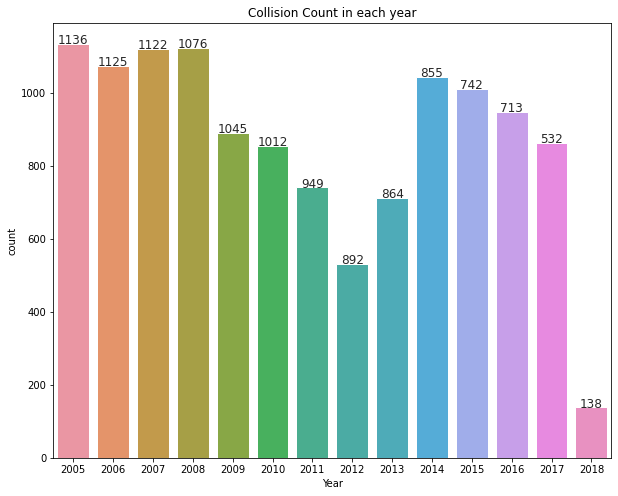

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x = 'Year', data = traffic_property, \
                   order = ['2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018'])
i = 0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,
        traffic_property['Year'].value_counts()[i],ha="center")
    i += 1
ax.set(title = 'Collision Count in each year')

This dataset contains collisions from year 2005 to year 2018. The accident number increases and gets to its peak at Year 2012. After that the number decreases and stabled at around 180 yearly.

Since Year 2018 only contains 20 observations, we could like to see whether that contains a whole year results. From the following result, we could see that the year 2018 only contains January and Febuary results.

In [ ]:
traffic_property[traffic_property['Year'] == '2018'].groupby(['Month'])['Month'].count()

Month
01    93
02    45
Name: Month, dtype: int64

#### 1.1.b By Month

[Text(0.5, 1.0, 'Collision Count By Month from Year 2005 to 2017')]

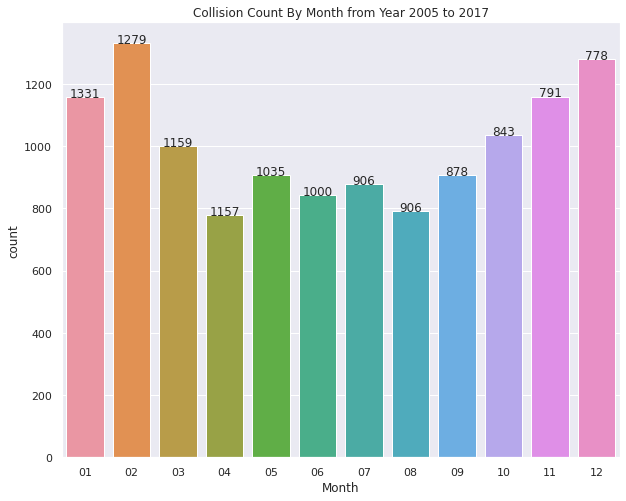

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x = 'Month', data = traffic_property[traffic_property['Year'] != '2018'], \
                   order = ['01','02','03','04','05','06','07','08','09','10','11','12'])
i = 0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,
        traffic_property[traffic_property['Year'] != '2018']['Month'].value_counts()[i],ha="center")
    i += 1
ax.set(title = 'Collision Count By Month from Year 2005 to 2017')

It seems that the colder the weather the more collision happened. That's why January, Febuary had the most.

During the May, June and July, it also seems to have a local peak.

We here include only year 2005 to 2017 since year 2018 contains only partial records.

#### 1.1.c Considering Day 

In [ ]:
from datetime import datetime

# map day based on the date
traffic_property['Weekday'] = pd.to_datetime(traffic_property['ACCIDENTDATE'], format = '%Y%m%d').dt.strftime('%A')

Text(0.5, 1.0, 'Traffic Collision in Year 2005 - 2018 in City of Waterloo')

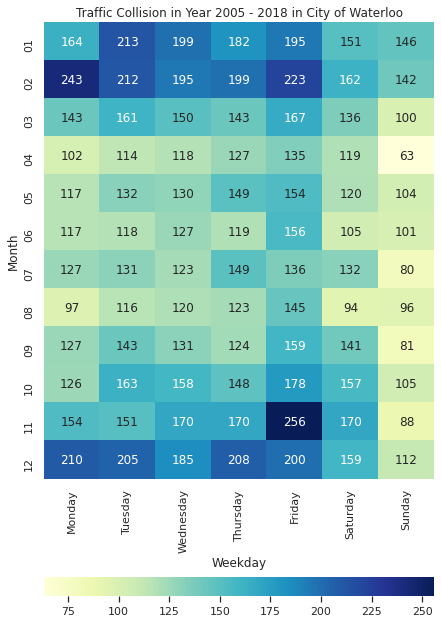

In [ ]:
# look at relationship between day and Month
traff_month_weekday = pd.crosstab(traffic_property['Month'], traffic_property['Weekday'])
traff_month_weekday = traff_month_weekday[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
fig = plt.figure(figsize = (7,12))
heat_month_weekday = sns.heatmap(traff_month_weekday, annot=True, fmt = 'd', cbar_kws= {'orientation':'horizontal'}, cmap="YlGnBu")
heat_month_weekday.set_title('Traffic Collision in Year 2005 - 2018 in City of Waterloo')

As seen in the heatmap, the number of accidents is generally higher during winter in terms of months and on Fridays in terms of weekday. 

### 1.2 Light Condition Analysis

[Text(0, 0, '01-Daylight'),
 Text(0, 0, '02-Daylight, artificial'),
 Text(0, 0, '03-Dawn'),
 Text(0, 0, '04-Dawn, artificial'),
 Text(0, 0, '05-Dusk'),
 Text(0, 0, '06-Dusk, artificial'),
 Text(0, 0, '07-Dark'),
 Text(0, 0, '08-Dark, artificial'),
 Text(0, 0, '99-Other')]

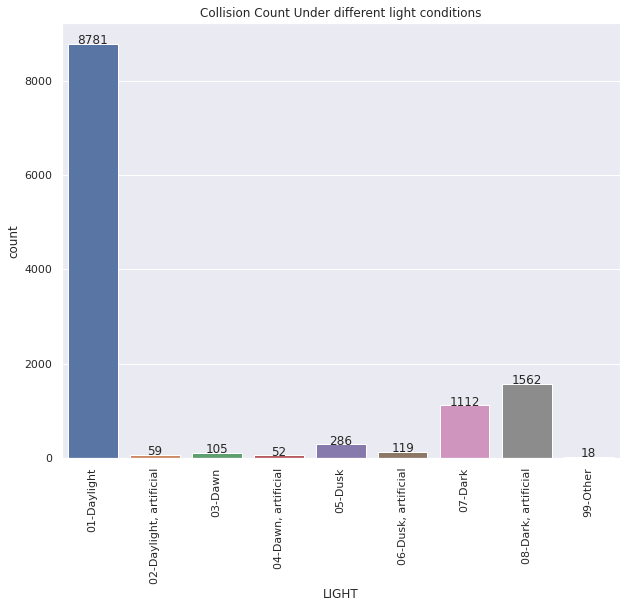

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x = 'LIGHT', data = traffic_property, order = ['01-Daylight','02-Daylight, artificial','03-Dawn','04-Dawn, artificial','05-Dusk','06-Dusk, artificial','07-Dark','08-Dark, artificial','99-Other'])
i = 0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,
        traffic_property['LIGHT'].value_counts()[['01-Daylight','02-Daylight, artificial','03-Dawn','04-Dawn, artificial','05-Dusk','06-Dusk, artificial','07-Dark','08-Dark, artificial','99-Other']][i],ha="center")
    i += 1
ax.set(title = 'Collision Count Under different light conditions')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

We could see that most of the collision happens at daylight without artificial light. It has collisions times more than the rest of the conditions. The second is the dark with artificial light and the third is dark condition.

We also would like to see how the light condition cross tab with weekdays.

Text(0.5, 1.0, 'Traffic Collision in Year 2005 - 2018 in City of Waterloo')

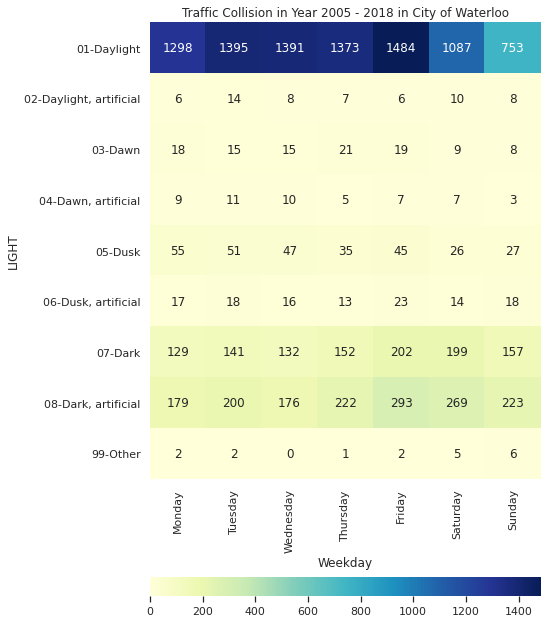

In [ ]:
traff_light_weekday = pd.crosstab(traffic_property['LIGHT'], traffic_property['Weekday'])
traff_light_weekday = traff_light_weekday[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
fig = plt.figure(figsize = (7,12))
heat_light_weekday = sns.heatmap(traff_light_weekday, annot=True, fmt = 'd', cbar_kws= {'orientation':'horizontal'}, cmap="YlGnBu")
heat_light_weekday.set_title('Traffic Collision in Year 2005 - 2018 in City of Waterloo')

We could see that Friday and Monday still have the most collision under daylight which is the same as we observed in the previous plot.

While for Dark condition in with or without Artificial light, Monday and Friday are still high but Saturday has the most. Sunday are also higher than that of Monday and Friday but still slightly lower than Saturday.

### 1.3 Accident Location and Impact Location

[Text(0, 0, '01-Non intersection'),
 Text(0, 0, '02-Intersection related'),
 Text(0, 0, '03-At intersection'),
 Text(0, 0, '04-At/near private drive'),
 Text(0, 0, '05-At railway crossing'),
 Text(0, 0, '06-Underpass or tunnel'),
 Text(0, 0, '07-Overpass or bridge'),
 Text(0, 0, '08-Trail'),
 Text(0, 0, '98-Other'),
 Text(0, 0, '99-Other')]

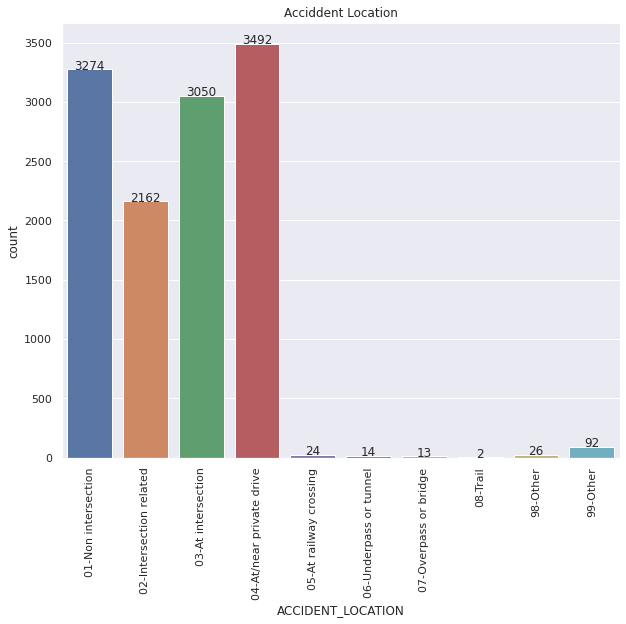

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x = 'ACCIDENT_LOCATION', data = traffic_property, order  = \
                   ['01-Non intersection','02-Intersection related','03-At intersection', \
                    '04-At/near private drive','05-At railway crossing','06-Underpass or tunnel', \
                    '07-Overpass or bridge','08-Trail','98-Other','99-Other'])
i = 0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,
        traffic_property['ACCIDENT_LOCATION'].value_counts()[['01-Non intersection','02-Intersection related','03-At intersection', \
                                                     '04-At/near private drive','05-At railway crossing','06-Underpass or tunnel', \
                                                     '07-Overpass or bridge','08-Trail','98-Other','99-Other']][i],ha="center")
    i += 1
ax.set(title = 'Acciddent Location')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

From the plot, we could see that most of the accidents happened at/near private drive or non-intersection. Other common places are intersection-related or at the intersection.

Since collision location will directly affect the impact location, let's see their crosstab heatmap.

Text(0.5, 1.0, 'Accident Location vs Impact Location')

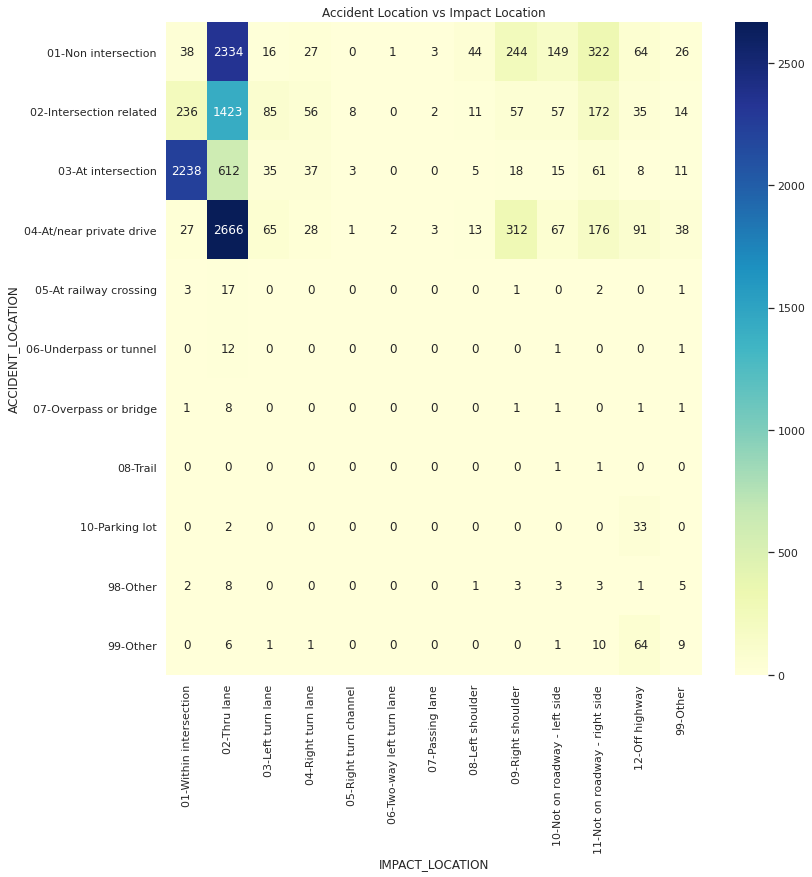

In [ ]:
acclocation_impact = pd.crosstab(traffic_property['ACCIDENT_LOCATION'], traffic_property['IMPACT_LOCATION'])
fig = plt.figure(figsize = (12,12))
heat_acclocation_impact = sns.heatmap(acclocation_impact, annot=True, fmt = 'd', cmap="YlGnBu")
heat_acclocation_impact.set_title('Accident Location vs Impact Location')

For accidents happen at `01-Non Intersection`, `02-Intersection Related` and `At/Near Private Drive`, it will most likely lead to `Thru Lane` impact. Also `Right Shoulder` and `Not on roadway-right-side` are also frequent impacts.

While for `03- At Intersection` collision, impacts are most likely happened at `Within Intersection`.

For collisions in `10-Parking Lot` and `99-Other`, `Off highway` is the most likely impact position. While `98-Other`, `On highway` will more likely to affect `Other` locations.



http://www.mto.gov.on.ca/graphics/english/trucks/cvor/accident-report-back.gif


### 1.4 Environment_Conditions




[Text(0, 0, '01-Clear'),
 Text(0, 0, '02-Rain'),
 Text(0, 0, '03-Snow'),
 Text(0, 0, '04-Freezing Rain'),
 Text(0, 0, '05-Drifting Snow'),
 Text(0, 0, '06-Strong wind'),
 Text(0, 0, '07-Fog, mist, smoke, dust'),
 Text(0, 0, '99-Other')]

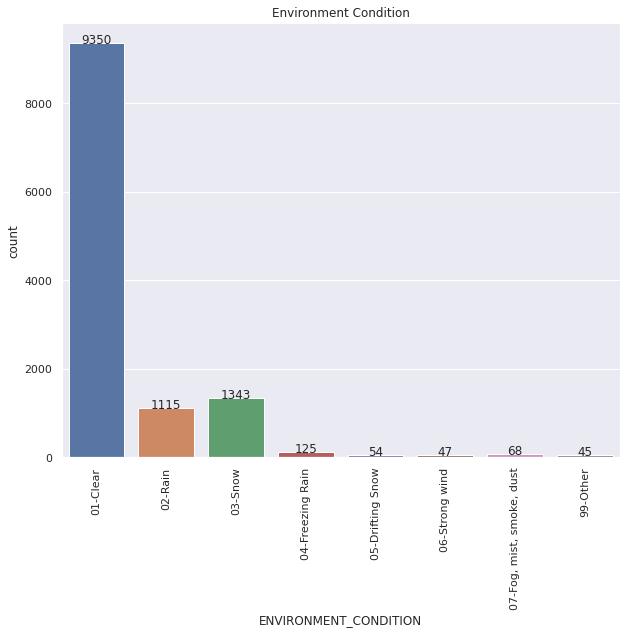

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x = 'ENVIRONMENT_CONDITION', data = traffic_property, order = \
                   ['01-Clear', '02-Rain', '03-Snow', '04-Freezing Rain', '05-Drifting Snow', \
                    '06-Strong wind', '07-Fog, mist, smoke, dust', '99-Other'])
i = 0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,
        traffic_property['ENVIRONMENT_CONDITION'].value_counts()[['01-Clear', '02-Rain', '03-Snow', '04-Freezing Rain', '05-Drifting Snow', \
                    '06-Strong wind', '07-Fog, mist, smoke, dust', '99-Other']][i],ha="center")
    i += 1
ax.set(title = 'Environment Condition')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

Text(0.5, 1.0, 'Environment Condition vs Month')

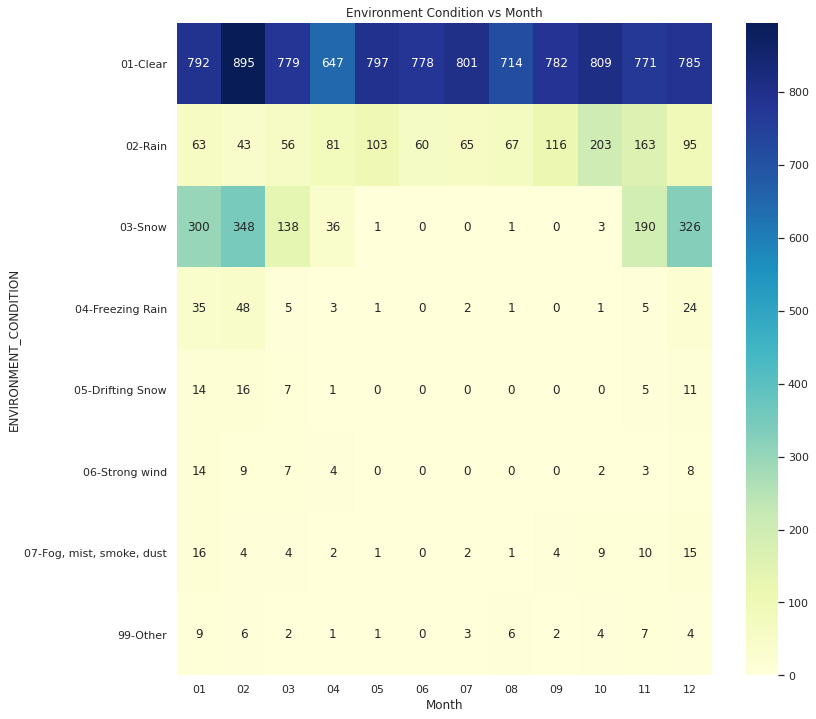

In [ ]:
enviro_month = pd.crosstab(traffic_property['ENVIRONMENT_CONDITION'], traffic_property['Month'])
fig = plt.figure(figsize = (12,12))
heat_enviro_month = sns.heatmap(enviro_month, annot=True, fmt = 'd', cmap="YlGnBu")
heat_enviro_month.set_title('Environment Condition vs Month')

The number of accidents happened during days when the weather was clear was significantly higher than all other weather conditions. 




### 1.5 Split the Location by @ or btwn

Since the `Location` here is contructed by two part using `@` or `btwn` to combine. Therefore, we would like to split them apart and using `1st_Road` to indicate the first road before `@` or `btwn` and `2nd_Road` to indicate the second road after `@` or `btwn`.

In [ ]:
# search for the location that contains either 'btwn' or '@'
# from the result, all the location contain at least one of the delimiter
searchfor = ['btwn','@']
sum(traffic_property['LOCATION'].str.contains('|'.join(searchfor)).tolist())

12201

In [ ]:
# search for the location that contains both 'btwn' or '@'
# none of the location contains more than one delimiter
# able to use these two delimiters to split all locations into two parts
searchfor = ['btwn','@']
sum(traffic_property['LOCATION'].str.contains('&'.join(searchfor)).tolist())

0

In [ ]:
traffic_property['LOCATION'] = traffic_property.LOCATION.str.replace('btwn', '@')
traffic_property[['1st_Road','2nd_Road']] = traffic_property.LOCATION.str.split(' @ ', expand= True)

## EDA - Part 2 Geometry



### 2.1 Add longitude and latitude information for each collision to the dataset

In [ ]:
# merge the long and lat to the traffic features
traffic_property[['long','lat']] = pd.DataFrame(pd.DataFrame(pd.DataFrame(traffic_coord).coordinates.tolist())[0].tolist())
traffic_property.head()

,OBJECTID,ACCIDENTNUM,ACCIDENTDATE,LOCATION,ACCIDENT_LOCATION,IMPACT_LOCATION,ENVIRONMENT_CONDITION,LIGHT,COLLISION_TYPE,TRAFFICCOLLISIONSID,Year,Month,Day,Weekday,1st_Road,2nd_Road,long,lat
0,1,13-118637,20130525,CEDAR ST N @ KING ST E / CEDAR ST S,02-Intersection related,02-Thru lane,01-Clear,01-Daylight,INTERSECTION,None,2013,05,25,Saturday,CEDAR ST N,KING ST E / CEDAR ST S,-80.483436,43.447337
1,2,13-019811,20130124,GLASGOW ST @ BELMONT AVE W,04-At/near private drive,02-Thru lane,01-Clear,01-Daylight,INTERSECTION,None,2013,01,24,Thursday,GLASGOW ST,BELMONT AVE W,-80.516995,43.451888
2,3,12-089689,20120418,CEDAR ST N @ KING ST E / CEDAR ST S,01-Non intersection,09-Right shoulder,01-Clear,01-Daylight,INTERSECTION,None,2012,04,18,Wednesday,CEDAR ST N,KING ST E / CEDAR ST S,-80.483436,43.447337
3,4,12-127500,20120601,BELMONT AVE W @ ARGYLE ST,03-At intersection,01-Within intersection,02-Rain,01-Daylight,INTERSECTION,None,2012,06,01,Friday,BELMONT AVE W,ARGYLE ST,-80.518436,43.454180
4,5,13-012564,20130115,STRASBURG RD @ HURON RD,03-At intersection,01-Within intersection,01-Clear,"08-Dark, artificial",INTERSECTION,None,2013,01,15,Tuesday,STRASBURG RD,HURON RD,-80.466222,43.391973


### 2.2 Import Ward information from City of Waterloo Open Data

In [ ]:
# geopandas are not pre-installed in google colab
!pip install geopandas

     |████████████████████████████████| 1.0MB 7.5MB/s 
     |████████████████████████████████| 15.3MB 266kB/s 
     |████████████████████████████████| 6.5MB 42.3MB/s 


In [ ]:
import geopandas as gpd
from geopandas.tools import sjoin
import pandas as pd
import matplotlib.pyplot as plt
from fiona.crs import from_epsg
from descartes.patch import PolygonPatch

In [ ]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [ ]:
# import other supporting dataset - ward for city of waterloo
ward_url = 'https://opendata.arcgis.com/datasets/aaa70fb878304de4ba244f12c5447016_0.geojson'
ward = requests.get(ward_url)
ward = gpd.GeoDataFrame().from_features(ward.json())

In [ ]:
ward

,geometry,OBJECTID,ADDRESS,POSTAL_CODE,WORK_PHONE,EMAIL,COUNCILLOR_NAME,COUNCILOR_BIO,COUNCILOR_MESSAGE,COUNCILOR_URL,CREATE_DATE,CREATE_BY,UPDATE_DATE,UPDATE_BY,WARDID,WARD,MAPLABEL1,RESIDENTIAL_HOUSEHOLD_COUNT,MPAC_POPULATION,MPAC_VOTERS,Shape__Area,Shape__Length
0,"POLYGON ((-80.51570 43.45838, -80.51568 43.458...",651,200 King St W,N2G4G7,519-741-2798,debbie.chapman@kitchener.ca,Debbie Chapman,None,None,https://www.kitchener.ca/en/city-services/coun...,2010-01-19T00:00:00Z,DAVIDV,2010-12-08T12:19:30Z,nancys,9,9,Ward 9,12147,653,634,8.120127e+06,14338.927082
1,"POLYGON ((-80.49625 43.40181, -80.49656 43.401...",652,200 King St W,N2G4G7,519-741-2793,paul.singh@kitchener.ca,Paul Singh,None,None,https://www.kitchener.ca/en/city-services/Coun...,2010-01-19T00:00:00Z,DAVIDV,2010-12-08T12:19:04Z,nancys,6,6,Ward 6,9351,717,685,6.975862e+06,10794.543237
2,"POLYGON ((-80.51895 43.45644, -80.51888 43.456...",653,200 King St W,N2G4G7,519-741-2796,margaret.johnston@kitchener.ca,Margaret Johnston,None,None,https://www.kitchener.ca/en/city-services/coun...,2010-01-19T00:00:00Z,DAVIDV,2010-12-08T12:19:19Z,nancys,8,8,Ward 8,10905,448,452,7.526118e+06,15052.413790
3,"POLYGON ((-80.41972 43.42176, -80.41730 43.420...",654,200 King St W,N2G4G7,519-741-2790,john.gazzola@kitchener.ca,John Gazzola,None,None,https://www.kitchener.ca/en/city-services/Coun...,2010-01-19T00:00:00Z,DAVIDV,2010-12-08T12:18:33Z,nancys,3,3,Ward 3,9010,1341,1297,1.927726e+07,22958.853011
4,"POLYGON ((-80.49678 43.40241, -80.49656 43.401...",655,200 King St W,N2G4G7,519-741-2791,kelly.galloway@kitchener.ca,Kelly Galloway-Sealock,None,None,https://www.kitchener.ca/en/city-services/Coun...,2010-01-19T00:00:00Z,DAVIDV,2010-12-08T12:18:51Z,nancys,5,5,Ward 5,10864,30,26,2.960906e+07,27272.835743
5,"POLYGON ((-80.47830 43.47351, -80.47711 43.472...",656,200 King St W,N2G4G7,519-741-2786,sarah.marsh@kitchener.ca,Sarah Marsh,None,None,https://www.kitchener.ca/en/city-services/Coun...,2010-01-19T00:00:00Z,DAVIDV,2010-12-08T12:19:34Z,nancys,10,10,Ward 10,12309,484,470,8.396375e+06,14739.180823
6,"POLYGON ((-80.41087 43.45694, -80.40826 43.456...",657,200 King St W,N2G4G7,519-741-3424,dave.schnider@kitchener.ca,Dave Schnider,None,None,https://www.kitchener.ca/en/city-services/Coun...,2010-01-19T00:00:00Z,DAVIDV,2010-12-08T12:18:28Z,nancys,2,2,Ward 2,12675,60,76,1.442277e+07,17180.380101
7,"POLYGON ((-80.47089 43.48719, -80.47088 43.486...",658,200 King St W,N2G4G7,519-741-2784,scott.davey@kitchener.ca,Scott Davey,None,None,https://www.kitchener.ca/en/city-services/coun...,2010-01-19T00:00:00Z,DAVIDV,2010-12-08T12:18:22Z,nancys,1,1,Ward 1,9983,30,27,1.671281e+07,24852.450741
8,"POLYGON ((-80.38587 43.39754, -80.39271 43.393...",659,200 King St W,N2G4G7,519-741-2779,christine.michaud@kitchener.ca,Christine Michaud,None,None,https://www.kitchener.ca/en/city-services/coun...,2010-01-19T00:00:00Z,DAVIDV,2010-12-08T12:18:39Z,nancys,4,4,Ward 4,10499,31,28,1.718885e+07,20202.508535
9,"POLYGON ((-80.54564 43.40940, -80.54806 43.409...",660,200 King St W,N2G4G7,519-741-2783,bil.ioannidis@kitchener.ca,Bil Ioannidis,None,None,https://www.kitchener.ca/en/city-services/Coun...,2010-01-19T00:00:00Z,DAVIDV,2010-12-08T12:19:18Z,nancys,7,7,Ward 7,9525,54,48,1.014105e+07,12875.640376


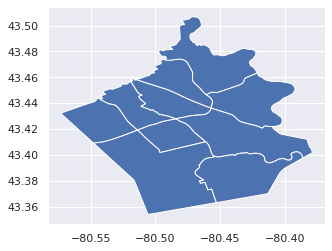

In [ ]:
# generel map of ward in Kitchener
ward.plot()

In [ ]:
# add centroid to the dataset for further preparation
ward['center'] = ward['geometry'].centroid

Here we obtain a geographical map of the Kichener area, with indication of each ward. 

### 2.3 Determine which Ward each collision location belongs to

In [ ]:
# change the polygon boundary plots into a list to for preparation whether the accident in that ward
ward_df = pd.json_normalize(requests.get(ward_url).json()['features'])[['properties.WARD','geometry.coordinates']]
ward_df.columns = ['ward_id','cood']

# each list contains the boundary plots of that polygan
ward_9 = pd.DataFrame(ward_df.cood[0]).T[0].tolist()
ward_6 = pd.DataFrame(ward_df.cood[1]).T[0].tolist()
ward_8 = pd.DataFrame(ward_df.cood[2]).T[0].tolist()
ward_3 = pd.DataFrame(ward_df.cood[3]).T[0].tolist()
ward_5 = pd.DataFrame(ward_df.cood[4]).T[0].tolist()
ward_10 = pd.DataFrame(ward_df.cood[5]).T[0].tolist()
ward_2 = pd.DataFrame(ward_df.cood[6]).T[0].tolist()
ward_1 = pd.DataFrame(ward_df.cood[7]).T[0].tolist()
ward_4 = pd.DataFrame(ward_df.cood[8]).T[0].tolist()
ward_7 = pd.DataFrame(ward_df.cood[9]).T[0].tolist()

In [ ]:
# function to determine each observation in which ward 

def ward_test(long, lat):
  # change into a point
  point = Point(long, lat)

  # set polygon
  polygon1 = Polygon(ward_1)
  polygon2 = Polygon(ward_2)
  polygon3 = Polygon(ward_3)
  polygon4 = Polygon(ward_4)
  polygon5 = Polygon(ward_5)
  polygon6 = Polygon(ward_6)
  polygon7 = Polygon(ward_7)
  polygon8 = Polygon(ward_8)
  polygon9 = Polygon(ward_9)
  polygon10 = Polygon(ward_10)

  # determine which ward it belongs to, whether the test list contain both '1' and '-1'
  ward_determine = []
  ward_determine.append(polygon1.contains(point))
  ward_determine.append(polygon2.contains(point))
  ward_determine.append(polygon3.contains(point))
  ward_determine.append(polygon4.contains(point))
  ward_determine.append(polygon5.contains(point))
  ward_determine.append(polygon6.contains(point))
  ward_determine.append(polygon7.contains(point))
  ward_determine.append(polygon8.contains(point))
  ward_determine.append(polygon9.contains(point))
  ward_determine.append(polygon10.contains(point))

  return ward_determine

In [ ]:
# apply the function to each collision (each row in traffic_property)
ward_result = [ward_test(x,y) for x,y in zip(traffic_property['long'], traffic_property['lat'])]
ward_result = pd.DataFrame(ward_result)
ward_result.head()

# True if that point is the ward, false if not

,0,1,2,3,4,5,6,7,8,9
0,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,False


In [ ]:
# sum up each row to check the accuarcy of the result
# in case one point is classified into two regions/wards
ward_result['sum'] = ward_result.sum(axis = 1)

In [ ]:
print(ward_result['sum'].unique()) # sum only contains 1 and 0 which means at most one ward for each row/collision
print(ward_result.shape[0]) # in all 4099 collisions/rows
print(sum(ward_result['sum'])) 

# among 12201 collisions, 12076 are in the wards explained by the open data provided by the city of waterloo.
# while the rest 125 are not

[1 0]
12201
12076


In [ ]:
# find out which rows do not belong to any ward
no_ward = ward_result.index[ward_result['sum'] == 0].tolist()
no_ward

[4,
 35,
 71,
 234,
 265,
 403,
 415,
 482,
 484,
 530,
 532,
 549,
 646,
 716,
 743,
 821,
 962,
 1027,
 1104,
 1156,
 1164,
 1203,
 1211,
 1335,
 1342,
 1468,
 1508,
 1552,
 1747,
 1753,
 1943,
 1964,
 2115,
 2260,
 2292,
 2314,
 2484,
 2512,
 2522,
 2578,
 2897,
 2905,
 2939,
 3170,
 3201,
 3305,
 3333,
 3370,
 3372,
 3407,
 3549,
 3584,
 3664,
 3690,
 3745,
 4055,
 4154,
 4185,
 4215,
 4250,
 4271,
 4293,
 4301,
 4462,
 4500,
 4550,
 4593,
 4685,
 4856,
 4898,
 4956,
 4963,
 5006,
 5050,
 5072,
 5140,
 5343,
 5360,
 5699,
 6188,
 6274,
 6437,
 6444,
 6445,
 6471,
 6477,
 6517,
 6571,
 6581,
 6704,
 6756,
 6816,
 6885,
 6886,
 6887,
 7090,
 7122,
 7184,
 7246,
 7247,
 7308,
 7407,
 7441,
 7459,
 7491,
 7496,
 7545,
 7567,
 7584,
 7585,
 7618,
 7765,
 8743,
 9826,
 10151,
 10302,
 10467,
 10882,
 11438,
 11673,
 11679,
 11695,
 11759,
 11817,
 12048]

In [ ]:
# since 1 for the ward the accident truely belongs to, 0 for rest
# for each row, the columns with largest value is its ward
ward_result['Ward'] = ward_result.iloc[:,0:10].idxmax(axis=1)

# since python starting from 0, add 1 for the result when merging to collision DF
traffic_property['Ward'] = ward_result['Ward']+1

### 2.4 Analysis based on the Wards

In [ ]:
# since some rows do not belong to any region, drop them before further process
traffic_property_ward = traffic_property.drop(traffic_property.index[no_ward])
traffic_property_ward.shape

# now we have 12076 rows all with wards

NameError: ignored

In [ ]:
# save the collision count in each ward as a new DF and rank by count in descending order
ward_count = traffic_property_ward.groupby(['Ward'])['Ward'].count().reset_index(name = 'count')
ward_count.columns = ['WARDID','count']
ward_count['collision_rank'] = ward_count['count'].rank(ascending=False)

In [ ]:
ward_count

,WARDID,count,collision_rank
0,1,920,5.0
1,2,882,7.0
2,3,1425,3.0
3,4,748,10.0
4,5,860,8.0
5,6,889,6.0
6,7,782,9.0
7,8,1192,4.0
8,9,2474,1.0
9,10,1904,2.0


### 2.5 Merge the collision count by ward with ward

In [ ]:
merged = ward.merge(ward_count, on ='WARDID', how = 'left')

In [ ]:
merged.head()

,geometry,OBJECTID,ADDRESS,POSTAL_CODE,WORK_PHONE,EMAIL,COUNCILLOR_NAME,COUNCILOR_BIO,COUNCILOR_MESSAGE,COUNCILOR_URL,CREATE_DATE,CREATE_BY,UPDATE_DATE,UPDATE_BY,WARDID,WARD,MAPLABEL1,RESIDENTIAL_HOUSEHOLD_COUNT,MPAC_POPULATION,MPAC_VOTERS,Shape__Area,Shape__Length,center,count,collision_rank
0,"POLYGON ((-80.51570 43.45838, -80.51568 43.458...",651,200 King St W,N2G4G7,519-741-2798,debbie.chapman@kitchener.ca,Debbie Chapman,None,None,https://www.kitchener.ca/en/city-services/coun...,2010-01-19T00:00:00Z,DAVIDV,2010-12-08T12:19:30Z,nancys,9,9,Ward 9,12147,653,634,8.120127e+06,14338.927082,POINT (-80.49055 43.44118),2474,1.0
1,"POLYGON ((-80.49625 43.40181, -80.49656 43.401...",652,200 King St W,N2G4G7,519-741-2793,paul.singh@kitchener.ca,Paul Singh,None,None,https://www.kitchener.ca/en/city-services/Coun...,2010-01-19T00:00:00Z,DAVIDV,2010-12-08T12:19:04Z,nancys,6,6,Ward 6,9351,717,685,6.975862e+06,10794.543237,POINT (-80.48818 43.41508),889,6.0
2,"POLYGON ((-80.51895 43.45644, -80.51888 43.456...",653,200 King St W,N2G4G7,519-741-2796,margaret.johnston@kitchener.ca,Margaret Johnston,None,None,https://www.kitchener.ca/en/city-services/coun...,2010-01-19T00:00:00Z,DAVIDV,2010-12-08T12:19:19Z,nancys,8,8,Ward 8,10905,448,452,7.526118e+06,15052.413790,POINT (-80.51753 43.43729),1192,4.0
3,"POLYGON ((-80.41972 43.42176, -80.41730 43.420...",654,200 King St W,N2G4G7,519-741-2790,john.gazzola@kitchener.ca,John Gazzola,None,None,https://www.kitchener.ca/en/city-services/Coun...,2010-01-19T00:00:00Z,DAVIDV,2010-12-08T12:18:33Z,nancys,3,3,Ward 3,9010,1341,1297,1.927726e+07,22958.853011,POINT (-80.43148 43.41349),1425,3.0
4,"POLYGON ((-80.49678 43.40241, -80.49656 43.401...",655,200 King St W,N2G4G7,519-741-2791,kelly.galloway@kitchener.ca,Kelly Galloway-Sealock,None,None,https://www.kitchener.ca/en/city-services/Coun...,2010-01-19T00:00:00Z,DAVIDV,2010-12-08T12:18:51Z,nancys,5,5,Ward 5,10864,30,26,2.960906e+07,27272.835743,POINT (-80.49513 43.38671),860,8.0


In [ ]:
merged['collision_rank'] = merged['collision_rank'].astype(int)

### 2.6 Create choropleth map

In [ ]:
import matplotlib.patheffects as PathEffects

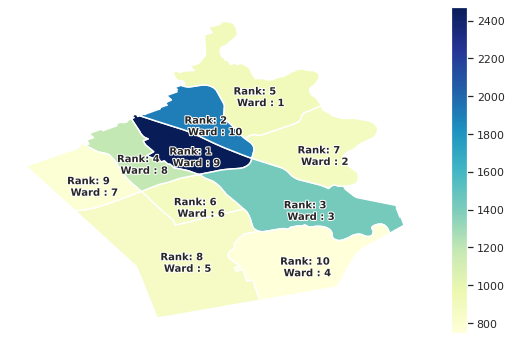

In [ ]:
# set the range for the choropleth
vmin = merged["count"].min()
vmax = merged["count"].max()

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

#create map
merged.plot(column="count", cmap="YlGnBu", linewidth=1.5, ax=ax)

# remove the axis
ax.axis("off")

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap="YlGnBu", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

#add rank labels
texts = []

for i in range(len(merged)):
    x = merged["center"][i].x-0.009
    y = merged["center"][i].y-0.009
    label = 'Rank: %s \n Ward : %s' % (merged["collision_rank"][i], merged['WARDID'][i])
    
    texts.append(plt.text(x, y, label, fontsize = 10, fontweight='bold' ). \
                 set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]))

Here we observe a high concentration in ward 10 and ward 9. 

# Model 

## Model - Part 1 Preparation

### 1.1 Data Cleaning

From all 19 columns, we would like to select:
+ column 4 - ACCIDENT_LOCATION
+ column 6 - ENVIRONMENT_CONDITION
+ column 7 - LIGHT
+ column 11 - Month
+ column 13 - Weekday
+ column 16 - log
+ column 17 - lat
+ column 18 - Ward

As for other variables,
+ `OBJECTID` and `ACCIDENTNUM` are unique for every collision, no prediction value
+ the date for every collision is split into year, month and day, therefore, `ACCIDENT_LOCATION` offers no extra value in prediction
+ `COLLISION_TYPE`,`IMPACT_LOCATION` is the consequence for collision, therefore should not be included in the predictors for estimating collision
+ `TRAFFICCOLLISIONSID` is null for every collision
+ `Year` should not be considered as a continuous variable because larger year number does not offer any quantifiable increase. Furthermore, the current dataset contains only 2005-2018 collision. If predicted for furture years that did not appear in the dataset, the model will not be able to process if considering year as categorical since future year is something that was not appeared in the training.
+ We think `Weekday` offers more suitable information than `Day`. For example, people might not drive at the 1st for each month but they will in most cases drive at the Monday for work. That's why we choose `Weekday` over `Day`.
+  `lat` and `long` could be used to represent the location of the accident. Therefore,`Location` `1st_Road` and `2nd_Road` are not longer needed. Another reason to erase these three variable from the prediction is because they all contain too many levels as categorical variables.

In [ ]:
traffic_pre = traffic_property_ward.iloc[:,[4,6,7,11,13,16,17,18]]
traffic_pre = traffic_pre.dropna()
traffic_pre = traffic_pre.astype({'Ward': object})
traffic_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11945 entries, 0 to 12200
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ACCIDENT_LOCATION      11945 non-null  object 
 1   ENVIRONMENT_CONDITION  11945 non-null  object 
 2   LIGHT                  11945 non-null  object 
 3   Month                  11945 non-null  object 
 4   Weekday                11945 non-null  object 
 5   long                   11945 non-null  float64
 6   lat                    11945 non-null  float64
 7   Ward                   11945 non-null  object 
dtypes: float64(2), object(6)
memory usage: 839.9+ KB


There is something else we would like to mention here:
+ The dataset just provide the date of the time, the hour or specific time information of the accident could not be found in the dataset.
+ The only variable able to determine the time period of that day is `LIGHT`, it contains levels:
  + 01-Daylight
  + 02-Daylight, artificial
  + 03-Dawn
  + 04-Dawn, artificial
  + 05-Dusk
  + 06-Dusk, artificial
  + 07-Dark
  + 08-Dark, artificial
  + 99-Other
Therefore, we would like to use this as a determination of time period in our project.

### 1.2 Generate Negative Examples

Since the dataset only contains records for accident, in order to predict whether the accident happens, we need also to make those no-accident records by ourselves.


In [ ]:
import random

In [ ]:
# add an extra column to identify the collision (original records)
traffic_all = traffic_pre
traffic_all['collision'] = 1

In [ ]:
# prepare the conditions for generate negative examples
weekday_for_new = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
light_for_new = ['01-Daylight','02-Daylight, artificial','03-Dawn','04-Dawn, artificial','05-Dusk','06-Dusk, artificial','07-Dark','08-Dark, artificial','99-Other']

In [ ]:
col_names = traffic_all.columns.to_list()

In [ ]:
# create an extra negative example for all rows in the dataset
for index, row in traffic_all.iterrows():
  i = 0
  while (i < 1):
    
    # this new example has the all same values except the weekday and light condition.
    # this new example implies - same month, same weather but different day and different time period
    # there might not be a accident

    # randomly pick condition
    day_rand, light_rand = random.randint(0,6), random.randint(0,8)
    light = light_for_new[light_rand] 
    weekday = weekday_for_new[day_rand]
    collision = 0

    # get value from current row
    lat = row['lat']
    long = row['long']
    month =  row['Month']
    acc_loc = row['ACCIDENT_LOCATION']
    envir = row['ENVIRONMENT_CONDITION']
    ward = row['Ward']

    # check if such record exist
    exist = traffic_pre[(traffic_pre['Weekday'] == weekday) & \
                            (traffic_pre['LIGHT'] == light) & \
                            (traffic_pre['lat'] == lat) & \
                            (traffic_pre['long'] == long) & \
                             (traffic_pre['Month'] == month)]
    if exist.empty:
      i += 1
      new_row = pd.DataFrame([[acc_loc,envir , light, month, weekday,  \
                               long, lat, ward, collision]], \
                             columns = col_names)
      traffic_all = traffic_all.append(new_row, ignore_index=True)
    else:
      # print to identity a duplicates records and regenerate a new negative example
      print('Already an accident!')

In [ ]:
traffic_all.shape

(23890, 9)

## Model - Part 2 Modeling

### 2.1 Logistic

In [ ]:
# split X and y
X = traffic_all.iloc[:,0:8]
y = traffic_all.collision

In [ ]:
# change all the categorical variable into category
for col in ['ACCIDENT_LOCATION','ENVIRONMENT_CONDITION','LIGHT','Month', \
            'Weekday','Ward']:
    X[col] = X[col].astype('category')

In [ ]:
# define dummy function to create dummy variables for each categorical variable
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname)
    col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

In [ ]:
X = create_dummies(X, 'ACCIDENT_LOCATION')
X = create_dummies(X, 'ENVIRONMENT_CONDITION')
X = create_dummies(X, 'LIGHT')
X = create_dummies(X, 'Month')
X = create_dummies(X, 'Weekday')
X = create_dummies(X, 'Ward')

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23890 entries, 0 to 23889
Data columns (total 53 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   long                                             23890 non-null  float64
 1   lat                                              23890 non-null  float64
 2   ACCIDENT_LOCATION_02-Intersection related        23890 non-null  uint8  
 3   ACCIDENT_LOCATION_03-At intersection             23890 non-null  uint8  
 4   ACCIDENT_LOCATION_04-At/near private drive       23890 non-null  uint8  
 5   ACCIDENT_LOCATION_05-At railway crossing         23890 non-null  uint8  
 6   ACCIDENT_LOCATION_06-Underpass or tunnel         23890 non-null  uint8  
 7   ACCIDENT_LOCATION_07-Overpass or bridge          23890 non-null  uint8  
 8   ACCIDENT_LOCATION_08-Trail                       23890 non-null  uint8  
 9   ACCIDENT_LOCATION_10-Parking

In [ ]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [ ]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

# prediction for logistic
y_pred_log=logreg.predict(X_test)

In [ ]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()


Optimization terminated successfully.
         Current function value: 0.371221
         Iterations 8


No handles with labels found to put in legend.


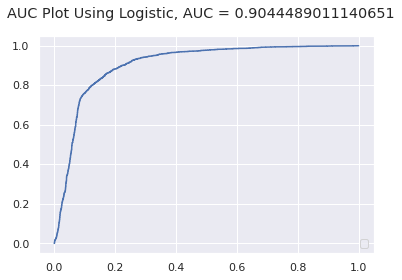

In [ ]:
from sklearn import metrics

y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_log = metrics.roc_auc_score(y_test, y_pred_proba)

fig = plt.figure()
fig.suptitle('AUC Plot Using Logistic, AUC = ' + str(auc_log))
plt.plot(fpr,tpr)
plt.legend(loc=4)
plt.show()

In [ ]:
# import the metrics class
from sklearn import metrics

# define confusion matix plot function
def confusion_matrix_plot(y_pred):
  pred_matrix = metrics.confusion_matrix(y_test, y_pred)

  class_names=[0,1] # name  of classes
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  # create heatmap

  sns.heatmap(pd.DataFrame(pred_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

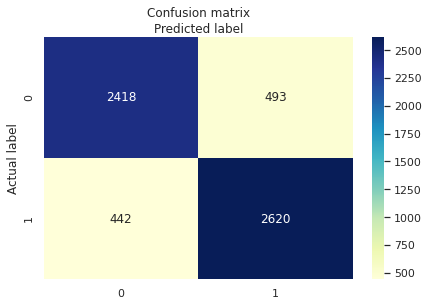

In [ ]:
confusion_matrix_plot(y_pred_log)

In [ ]:
# accuracy, precision, recall and f1 will be chosen to evaluate model
result_col = ['model','accuracy','precision','recall','F1-score','AUC']

# create a result dataframe for model comparson
result = []

In [ ]:
# create function for save and print other model evalution 
def model_result(y_pred ,auc, name,result):

  # get result
  acc = metrics.accuracy_score(y_test, y_pred)
  prec = metrics.precision_score(y_test, y_pred)
  rec = metrics.recall_score(y_test, y_pred)
  f1 = metrics.f1_score(y_test, y_pred)

  # print result
  print(name, "Accuracy:",acc)
  print(name,"Precision:",prec)
  print(name,"Recall:",rec)
  print(name,'F1-score',f1)

  #save into result dataframe
  new_row = [name,acc , prec, rec, f1,auc]
  result = result.append(new_row)

In [ ]:
model_result(y_pred_log,auc_log, 'Logistic Regression',result)

Logistic Regression Accuracy: 0.8434622467771639
Logistic Regression Precision: 0.8416318663668487
Logistic Regression Recall: 0.8556499020248204
Logistic Regression F1-score 0.848582995951417


In [ ]:
result

[['Logistic Regression',
  0.8434622467771639,
  0.8416318663668487,
  0.8556499020248204,
  0.848582995951417,
  0.9044489011140651]]

### 2.2 Random Forest

#### 2.2.1 Using Default Hyperparameters

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
rf=RandomForestClassifier(random_state=100)

#Train the model using the training sets
rf.fit(X_train,y_train)

# prediction
y_pred_rf = rf.predict(X_test)

In [ ]:
from pprint import pprint

# get paramters from the default random forest
pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 100,
 'verbose': 0,
 'warm_start': False}


No handles with labels found to put in legend.


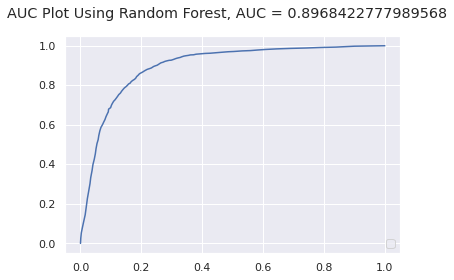

In [ ]:
y_pred_proba_rf = rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_rf)
auc_rf = metrics.roc_auc_score(y_test, y_pred_proba_rf)

fig = plt.figure()
fig.suptitle('AUC Plot Using Random Forest, AUC = ' + str(auc_rf))
plt.plot(fpr,tpr)
plt.legend(loc=4)
plt.show()

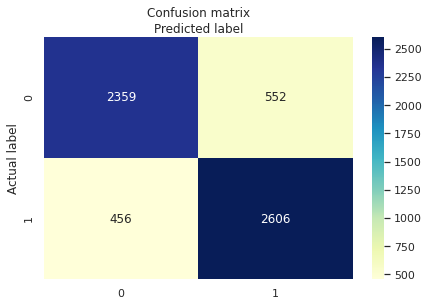

In [ ]:
# confusion matrix
confusion_matrix_plot(y_pred_rf)

In [ ]:
# model evaluation
model_result(y_pred_rf,auc_rf,'Random Forest with Default',result)

Random Forest with Default Accuracy: 0.8312405826217981
Random Forest with Default Precision: 0.8252058264724509
Random Forest with Default Recall: 0.8510777269758328
Random Forest with Default F1-score 0.8379421221864952


#### 2.2.1 Tune Hyperparameters

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest - default using 100
n_estimators = [10, 30, 50, 70, 100, 200, 500,1000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [3,5,7,9]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True],
 'max_depth': [3, 5, 7, 9, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 30, 50, 70, 100, 200, 500, 1000]}


In [ ]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, \
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
# best tuning paremeters result
rf_random.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# fit the random forest with best esitmator
rf_tune = rf_random.best_estimator_
rf_tune.fit(X_train,y_train)

# prediction with best estimator
y_pred_rf_tune = rf_tune.predict(X_test)

No handles with labels found to put in legend.


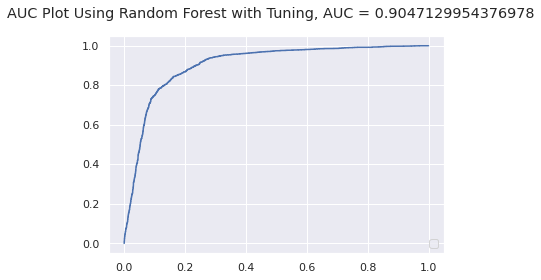

In [ ]:
# ROC - AUC curve
y_pred_proba_tune = rf_tune.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_tune)
auc_rf_tune = metrics.roc_auc_score(y_test, y_pred_proba_tune)

fig = plt.figure()
fig.suptitle('AUC Plot Using Random Forest with Tuning, AUC = ' + str(auc_rf_tune))
plt.plot(fpr,tpr)
plt.legend(loc=4)
plt.show()

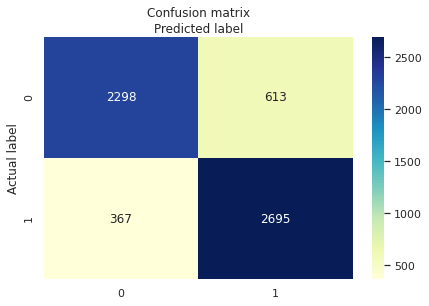

In [ ]:
# confusion matrix
confusion_matrix_plot(y_pred_rf_tune)

In [ ]:
# model evaluation
model_result(y_pred_rf_tune,auc_rf_tune,'Random Forest with Tuning',result)

Random Forest with Tuning Accuracy: 0.835928344215637
Random Forest with Tuning Precision: 0.8146916565900847
Random Forest with Tuning Recall: 0.8801436969301111
Random Forest with Tuning F1-score 0.8461538461538463


No handles with labels found to put in legend.


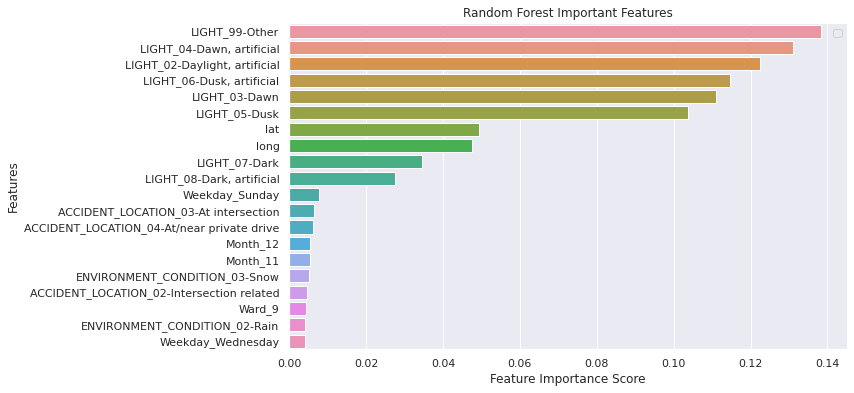

In [ ]:
# feature importance for random forest
feature_imp = pd.Series(rf_tune.feature_importances_,index=X.columns).sort_values(ascending=False)

# Creating a bar plot for feature importance top 20
plt.subplots(figsize=(10, 6))
sns.barplot(x=feature_imp[:20], y=feature_imp.index[:20])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Random Forest Important Features")
plt.legend()
plt.show()

### 2.3 XGBoost

#### 2.3.1 Using Default Hyperparameters

In [ ]:
# import XGB model for classification
from xgboost import XGBClassifier

# create a model
xgb = XGBClassifier(seed = 1000)

# fit 
xgb.fit(X_train, y_train)

# predict
y_pred_xgb = xgb.predict(X_test)

No handles with labels found to put in legend.


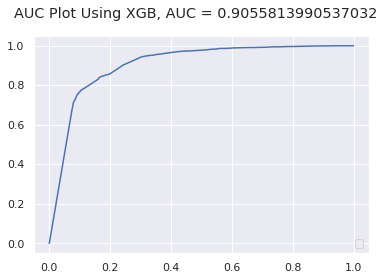

In [ ]:
# ROC - AUC curve
y_pred_proba_xgb = xgb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_xgb)
auc_xgb = metrics.roc_auc_score(y_test, y_pred_proba_xgb)

fig = plt.figure()
fig.suptitle('AUC Plot Using XGB, AUC = ' + str(auc_xgb))
plt.plot(fpr,tpr)
plt.legend(loc=4)
plt.show()

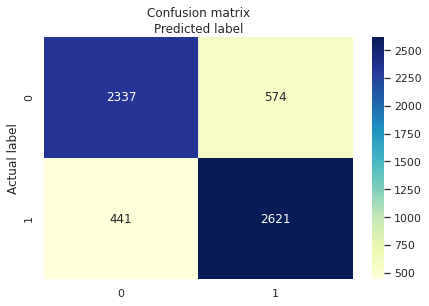

In [ ]:
# confustion matrix for prediction based on XGB
confusion_matrix_plot(y_pred_xgb)

In [ ]:
# model result evalution
model_result(y_pred_xgb,auc_xgb, 'XGBoosting with Default',result)

XGBoosting with Default Accuracy: 0.8300686422233383
XGBoosting with Default Precision: 0.8203442879499218
XGBoosting with Default Recall: 0.8559764859568909
XGBoosting with Default F1-score 0.837781684513345


In [ ]:
# get paramters from the default xgb
pprint(xgb.get_params())

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 1000,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}


#### 2.3.2 Tune Hyperparameters

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# learning_rate - default = 0.1
learning_rate = [0.01,0.05,0.1,0.2]
# columns randomly selected at each tree - default  = 1
colsample_bytree = [0.5, 0.75, 1]
# sample selected for prediction at each split
subsample = [0.5, 0.75 , 1]

# Create the random grid
xgb_grid = {'learning_rate': learning_rate,
               'colsample_bytree': colsample_bytree,
               'subsample': subsample}

In [ ]:
# Use the grid to search for best hyperparameters

# define classifier
xgb = XGBClassifier(seed = 1000)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = xgb_grid, \
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
xgb_random.fit(X_train,y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  2.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=1000, silent=None, subsample=1,
                                           verbosity=1),
                   iid='de

In [ ]:
# result for the best estimator
xgb_random.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1000,
              silent=None, subsample=0.75, verbosity=1)

In [ ]:
# fit the xgb with best esitmator
xgb_tune = xgb_random.best_estimator_
xgb_tune.fit(X_train,y_train)

# prediction with best estimator
y_pred_xgb_tune = xgb_tune.predict(X_test)

No handles with labels found to put in legend.


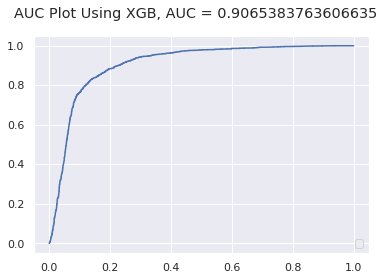

In [ ]:
# ROC - AUC curve
y_pred_proba_xgb_tune = xgb_tune.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_xgb_tune)
auc_xgb_tune = metrics.roc_auc_score(y_test, y_pred_proba_xgb_tune)

fig = plt.figure()
fig.suptitle('AUC Plot Using XGB, AUC = ' + str(auc_xgb_tune))
plt.plot(fpr,tpr)
plt.legend(loc=4)
plt.show()

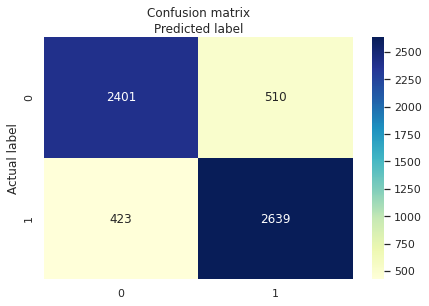

In [ ]:
# confusion matrix
confusion_matrix_plot(y_pred_xgb_tune)

In [ ]:
# model evaluation
model_result(y_pred_xgb_tune,auc_xgb_tune,'XGBoosting after Tuning',result)

XGBoosting after Tuning Accuracy: 0.8437970868910095
XGBoosting after Tuning Precision: 0.8380438234360115
XGBoosting after Tuning Recall: 0.8618549967341607
XGBoosting after Tuning F1-score 0.8497826436966672


## Model - Part 3 Comparison

In [ ]:
# result for each model in the previous section
result_df = pd.DataFrame(result, columns=result_col)
result_df = result_df.set_index('model')
result_df

,accuracy,precision,recall,F1-score,AUC
model,,,,,
Logistic Regression,0.843462,0.841632,0.855650,0.848583,0.904449
Random Forest with Default,0.831241,0.825206,0.851078,0.837942,0.896842
Random Forest with Tuning,0.835928,0.814692,0.880144,0.846154,0.904713
XGBoosting with Default,0.830069,0.820344,0.855976,0.837782,0.905581
XGBoosting after Tuning,0.843797,0.838044,0.861855,0.849783,0.906538


[Text(0.5, 1.0, 'Model Comparison')]

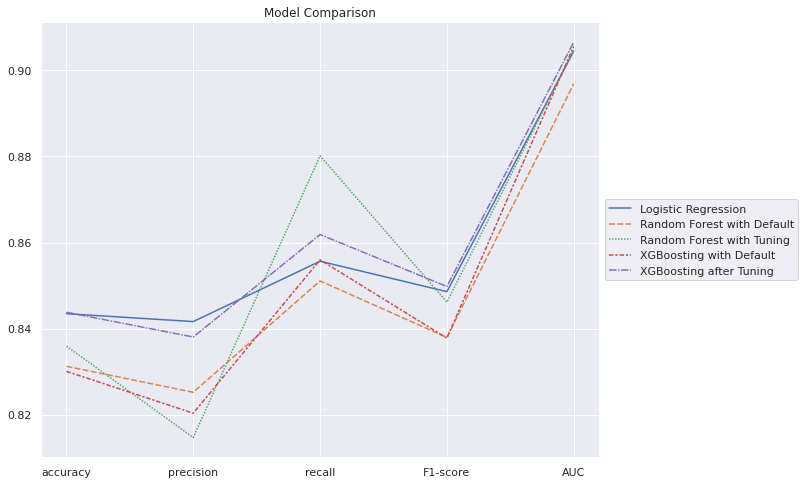

In [ ]:
fig = plt.subplots(figsize=(10,8))
p = sns.lineplot(data = result_df.T)
p.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
p.set(title = 'Model Comparison')

From the comparison, we would see that Logistic Regression and XGBoosting behave realtively stable in similar ways except for differences in precision and recall. 

Now, precision is calculated by the ratio of true positive to actual results, which is the percentage of relavent results; while recall is the ratio of true positive to predicted results, which is the percentage of correctly classified relavent results. As their F1-scores are very close, it is necessary to assess the importance of precision and recall in this situation. 

In the case of predicting traffic accidents, a model with high precision and low recall generates few results but accurate compared to the traning set; a model with low precision and high recall produces abundant results but many are incorrect compared to the training set. While it is more intuitive to investigate the areas where accidents happen more usually, therefore a higher precision is expected in the model, because a low precision, high recall model would give a more abundant amount of possible locations for an accident to happen, although covering the true results, it seems redundant for our purposes. Our purposes here are not merely to cover all possible outcomes but rather identify the patterns. 

## Model - Part 4 Further Prediction Using Logistic
What to input for each prediction:

+ Accident Location - what type of collision what to predict
  + 01-Non intersection
  + 02-Intersection related
  + 03-At intersection
  + 04-At/near private drive
  + 05-At railway crossing
  + 06-Underpass or tunnel
  + 07-Overpass or bridge
  + 08-Trail
  + 98-Other
  + 99-Other
+ Environment Condition - weather
  + 01-Clear
  + 02-Rain
  + 03-Snow
  + 04-Freezing Rain
  + 05-Drifting Snow
  + 06-Strong wind
  + 07-Fog, mist, smoke, dust
  + 99-Other
+ Light - what time period of each day
  + 01-Daylight
  + 02-Daylight, artificial
  + 03-Dawn
  + 04-Dawn, artificial
  + 05-Dusk
  + 06-Dusk, artificial
  + 07-Dark
  + 08-Dark, artificial
  + 99-Other
+ Month
+ Weekday
+ Longtitude
+ Latitude
+ Ward




### 4.1 Preparation

Using the original geographic locations, steps to change the dataset to fit in the model:
+ use the `ACCIDENT_LOCATION`,`long`,`lat` and `Ward` from originial dataset


In [ ]:
# create a new dataframe for prediction and copy the columns that could be used direcly
new_daylight = X
new_dark = X

+ Use the current date for `Month` and `Weekday`

In [ ]:
# change all the weekday to targe month
from datetime import datetime
current_month = 'Month_' + '{0:0=2d}'.format(datetime.now().month)
month_col = [i for i in X.columns if 'Month' in i]

for i in month_col:
  if i == current_month:
    new_daylight[i] = 1
    new_dark[i] = 1
  else:
    new_daylight[i] = 0
    new_dark[i] = 0

In [ ]:
# change all the weekday to targe weekday
from datetime import datetime
current_day = 'Weekday_' + datetime.now().strftime('%A')
day_col = [i for i in X.columns if 'Weekday' in i]

for i in day_col:
  if i == current_day:
    new_daylight[i] = 1
    new_dark[i] = 1
  else:
    new_daylight[i] = 0
    new_dark[i] = 0

+ `LIGHT` is `01-Daylight`
+ `LIGHT` is `08-Dark, artificial`

In [ ]:
# change to targe light
def prepare_light(light, df):
  current_light = 'LIGHT_' + light
  light_col = [i for i in X.columns if 'LIGHT' in i]

  # 1 for columns with target, 0 for not
  for i in light_col:
    if i == current_light:
      df[i] = 1
    else:
      df[i] = 0

In [ ]:
prepare_light('01-Daylight', new_daylight)
prepare_light('08-Dark, artificial', new_dark)

+ `ENVIRONMENT_CONDITION` is `01-Clear`

In [ ]:
# change to target environment condition
def prepare_enviro(enviro,df):
  current_enviro = 'ENVIRONMENT_CONDITION_' + enviro
  enviro_col = [i for i in X.columns if 'ENVIRONMENT_CONDITION_' in i]

  # 1 for columns with target, 0 for not
  for i in enviro_col:
    if i == current_enviro:
      df[i] = 1
    else:
      df[i] = 0

In [ ]:
prepare_enviro('01-Clear',new_daylight)
prepare_enviro('01-Clear',new_dark)

In [ ]:
new_daylight = new_daylight.drop_duplicates()
new_daylight = new_daylight.dropna()
new_daylight.shape

(4483, 53)

In [ ]:
new_dark = new_dark.drop_duplicates()
new_dark = new_dark.dropna()
new_dark.shape

(4483, 53)

### 4.2 Prediction Functions

In [ ]:
# prediction for new daylight
new_day_pred = pd.DataFrame(logreg.predict(new_daylight))
new_day_pred.columns = ['collision']

# prediction for new dark
new_dark_pred = pd.DataFrame(logreg.predict(new_dark))
new_dark_pred.columns = ['collision']

In [ ]:
# add lat and long information to dataset
new_day_pred[['lat','long']] = new_daylight[['lat','long']]
new_dark_pred[['lat','long']] = new_dark[['lat','long']]


In [ ]:
# keep only collision happen records
new_dark_pred_not0 = new_dark_pred[new_dark_pred['collision'] == 1]
new_day_pred_not0 = new_day_pred[new_day_pred['collision'] == 1]

# drop none
new_dark_pred_not0 = new_dark_pred_not0.dropna()
new_day_pred_not0 = new_day_pred_not0.dropna()

### 4.3 Prediction Result Visualization

#### 4.3.1 Daylight

Individual potential accident

In [ ]:
import folium
# Instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# Loop through the prediction and add each to the incidents feature group
for lat, long, in zip(new_day_pred_not0.lat, new_day_pred_not0.long):
    incidents.add_child(
        folium.CircleMarker(
            [lat, long],
            radius=7, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='red',
            fill_opacity=0.4
        )
    )

# Add incidents to map
latitude = 43.4248266559218
longitude = -80.4710640202469
day_map = folium.Map(location=[latitude, longitude], zoom_start=12)
day_map.add_child(incidents)

In [ ]:
## collision degree in the area

from folium.plugins import HeatMap

# let's start again with a clean copy of the map
day_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

# Convert data format
heatdata = new_day_pred_not0[['lat','long']].values.tolist()

# add incidents to map
HeatMap(heatdata).add_to(day_map)

day_map

The maps show locations where accidents are highly likely to happen during daytime. 

#### 4.3.2 Dark

In [ ]:
import folium
# Instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# Loop through the prediction and add each to the incidents feature group
for lat, long, in zip(new_dark_pred_not0.lat, new_dark_pred_not0.long):
    incidents.add_child(
        folium.CircleMarker(
            [lat, long],
            radius=7, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='red',
            fill_opacity=0.4
        )
    )

# Add incidents to map
latitude = 43.4248266559218
longitude = -80.4710640202469
day_map = folium.Map(location=[latitude, longitude], zoom_start=12)
day_map.add_child(incidents)

In [ ]:
## collision degree in the area

from folium.plugins import HeatMap

# let's start again with a clean copy of the map
day_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

# Convert data format
heatdata = new_dark_pred_not0[['lat','long']].values.tolist()

# add incidents to map
HeatMap(heatdata).add_to(day_map)

day_map

The maps show locations where accidents are highly likely to happen during nighttime.

## Conclusion


In the EDA section, we discovered that the number of accidents is generally higher during winter in terms of months and on Fridays in terms of weekday. In terms of time during the day, most of the collision happens at daylight without artificial light. Considering impact locations, most of the accidents happened at/near private drive or non-intersection. And the number of accidents happened during days when the weather was clear was significantly higher than all other weather conditions.Geographically we observe a high concentration in ward 10 and ward 9. 

By comparing 5 models, Random Forest with default and tuning, Logistic Regression, XGBoost with default and tuning, we picked Logistic Regression for further prediction analysis as it has higher precision and lower recall than XGBoost. 

With the selected model we were able to predict the locations that accidents are highly likely to happen in a given time period of a day and a give weather condition. 